In [1]:
import importlib
import pandas as pd
import analysis_functions as af
import analysis_functions_behv as af_b
import preprocess_behav2p as preprocess
importlib.reload(af_b)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import stats
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d
import os
import pickle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
import pandas as pd
import openpyxl

In [4]:
desktop_path = os.path.expanduser(r"Y:\public\projects\SaEl_20220201_VIP\2pdata\LC\vipsilencing\LC11_Vip-\D\behavior_data\data.pkl")
with open(desktop_path, 'rb') as f:
    data = pickle.load(f)

In [15]:
piezo = data['Piezo_Signal'].to_numpy()

In [ ]:
# 15fps

In [ ]:
trial = 182
lick_data = data['aligned_data']['Piezo_Signal']
plt.plot(lick_data[data['trial_start_indices'][trial]:data['trial_start_indices'][trial+2]])
plt.axvline(x=data['reward_indices'][trial+1][0], color='r')
plt.axvline(x=data['reward_indices'][trial+2][0], color='r')
plt.axhline(y=2,color='r')

KeyError: 'trial_start_indices'

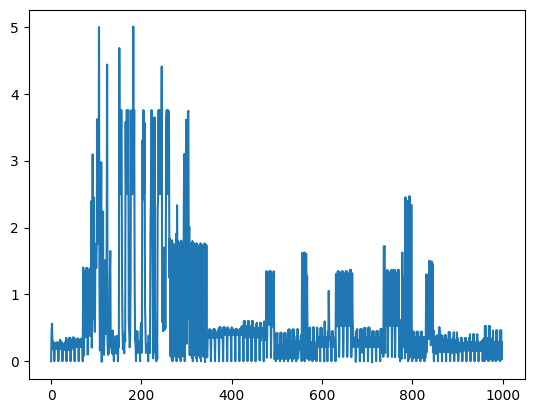

In [317]:
plt.plot(data['aligned_data']['Piezo_Signal'][:1000])

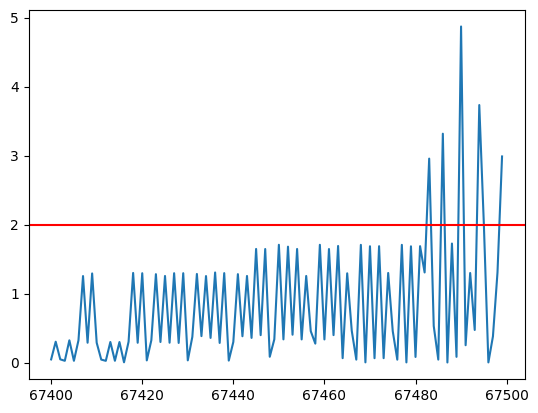

In [311]:
lick_data = data['aligned_data']['Piezo_Signal']
plt.plot(lick_data[67400:67500])
plt.axhline(y=2,color='r')

In [292]:
max_valid = 5
min_interval = 1.5
lick_signal_raw = np.clip(data['aligned_data']['Piezo_Signal'], a_min=None, a_max=max_valid)

lick_onsets = []
threshold = 2
above = lick_signal_raw > threshold
above = above.to_numpy()
crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

if len(crossings) > 0:
    filtered = [crossings[0]]
    for idx in crossings[1:]:
        if idx-filtered[-1] > min_interval:
            filtered.append(idx)
    lick_onsets.extend(filtered)

lick_onsets = np.array(lick_onsets)

lick_record = []
window = 30
sampling_rate = 15 # Hz
n_samples = len(lick_signal_raw)
lick_record = np.zeros(n_samples)
lick_record[lick_onsets] = 1

lick_rate = []
# Sliding window average (2s)
lick_number_per_sample = uniform_filter1d(lick_record, size=window, mode='constant')
# Convert to licks per second
lick_rate = lick_number_per_sample * sampling_rate


print(lick_onsets)
print(lick_record)
print(lick_rate)

[   376    379    387 ... 100292 100298 100302]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [294]:
ani_positions = (data['position']* 700/5).to_numpy() 
aligned_exp = []
aligned_unexp = []
for i, trial_start in enumerate(data['trial_start_indices']):   # i is the trial number and trial_start is the index
    if i < len(data['trial_start_indices']) - 1:   
        trial_end = data['trial_start_indices'][i+1]   
    else:
        trial_end = len(data['position'])
    for num, lick in enumerate(lick_record[trial_start:trial_end]):   # num is the index in [trial_start:trial_end]
        if lick == 1 and i in data['unpred_trials']['gr_2']:
            aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
        if lick == 1 and i in data['pred_trials']:
            aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
aligned_exp = np.array(aligned_exp)
aligned_unexp = np.array(aligned_unexp)

print(aligned_exp.shape)
print(aligned_unexp.shape)

(2216, 2)
(838, 2)


In [ ]:
# reward onset: 10.6

reward = data['aligned_data']['Reward'].to_numpy()
for i, r in enumerate(reward):
    if r == 1:
        print(data['position'][i])

10.598215099999999
10.600931466666667
10.59876925
10.6006408
10.6001401
10.614466700000001
10.600620355555556
10.600957716666667
10.600115777777779
10.597783391666669
10.599441075000001
10.605099333333333
10.603291
10.601833666666668
10.6011648
10.598215083333333
10.600548433333332
10.599760933333332
10.6045734
10.6025901
10.5990658
10.59992621111111
10.60604635
10.60276605
10.604633666666668
10.602974133333333
10.59875368888889
10.6043401
10.603031466666666
10.599548655555557
10.600114277777779
10.589526833333334
10.599695544444444
10.604867400000002
10.601490444444444
10.599758055555556
10.601849577777777
10.634880525
10.603494211111112
10.660640077777778
10.598572483333333
10.594559675000001
10.620618683333333
10.59405995
10.6013438
10.59983721111111
10.597747777777776
10.598265355555556
10.608763083333333
10.6210173
10.601417455555556
10.610257133333334
10.612750066666667
10.598837188888888
10.597867808333334
10.60838635
10.5995902
10.60461555
10.596666222222224
10.601771044444446


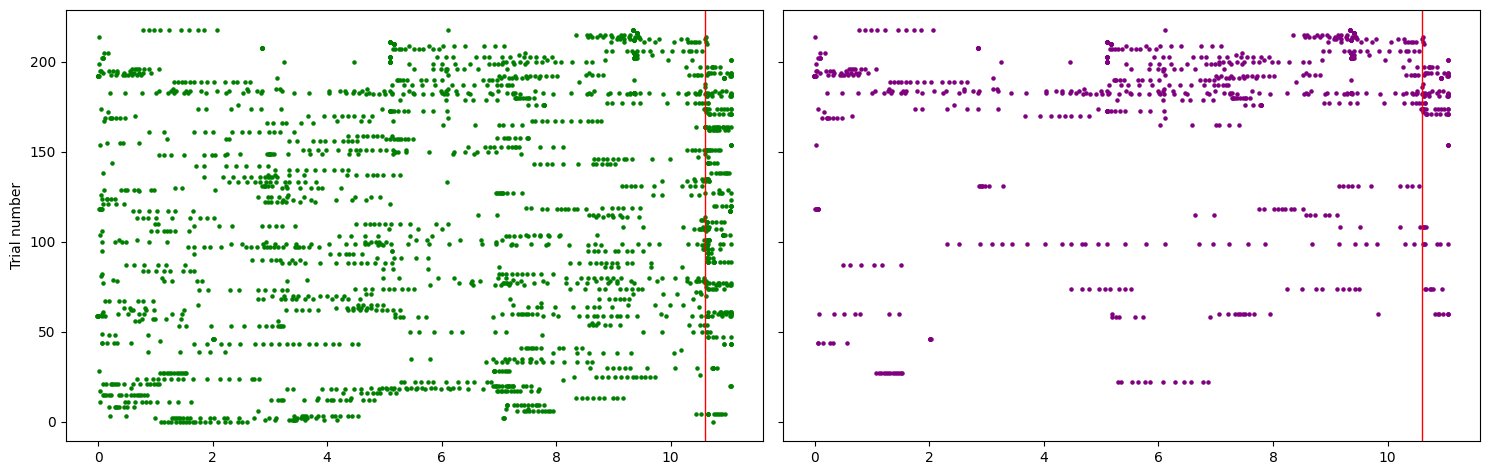

In [309]:
def plot_lick_data(data):  # function that plot lick raster
    ani_positions = data['position'].to_numpy()
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data['trial_start_indices']) - 1:   
            trial_end = data['trial_start_indices'][i+1]   
        else:
            trial_end = len(data['position'])
        for num, lick in enumerate(lick_record[trial_start:trial_end]):   # num is the index in [trial_start:trial_end]
            if lick == 1 and i in data['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    axes[1].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[0].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[0].axvline(x=10.6, color='red', linestyle='-', linewidth=1, label='Reward position')
    axes[1].axvline(x=10.6, color='red', linestyle='-', linewidth=1, label='Reward position')
    # axes[0].set_title('Control')
    # axes[0].set_xlabel('Position (cm)')
    axes[0].set_ylabel('Trial number')
    fig.suptitle('')
    plt.tight_layout()
    plt.show()
    
    # axes[0].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1, label='Grating 2 position')


plot_lick_data(data)

In [ ]:
# find lick indices in nondownsampled data and get lick_onsets/lick_records/lick_rate in downsampled data--- ctl

lick_onsets_ctl = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

max_valid = 5
min_interval = 100   # refractory period in samples

for ani in data_ctl_full:
    lick_onsets_ctl[ani] = []
    lick_signal_raw = np.clip(data_ctl_full[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = gaussian_filter1d(lick_signal_raw, sigma=0.1)  # no smoothing

    trial_start_indices = data_ctl_full[ani]['trial_start_indices']

    # iterate over all trials
    for tri in range(len(trial_start_indices) - 1):
        start = trial_start_indices[tri]
        end = trial_start_indices[tri + 1]
        segment = lick_signal[start:end]
        
        # compute per-trial threshold
        # threshold = 0.4
        threshold = np.median(segment) + 3 * np.std(segment)

        # find threshold crossings
        above = segment > threshold
        crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

        # convert local indices to absolute indices
        if len(crossings) > 0:
            # enforce refractory period (in absolute frame)
            abs_cross = start + crossings
            if len(abs_cross) > 0:
                filtered = [abs_cross[0]]
                for idx in abs_cross[1:]:
                    if idx - filtered[-1] >= min_interval:
                        filtered.append(idx)
                lick_onsets_ctl[ani].extend(filtered)

# convert to numpy arrays and visualise 
for ani in lick_onsets_ctl:
    lick_onsets_ctl[ani] = np.array(lick_onsets_ctl[ani])

    trial_start_indices = data_ctl_full[ani]['trial_start_indices']
    start, end = trial_start_indices[15], trial_start_indices[20]
    lick_signal = data_ctl_full[ani]['lick'] 
    axes[ani].plot(lick_signal[start:end])
    axes[ani].set_title(f'{ani}')
    # axes[ani].axhline(0.2,c='red')

    onsets_in_segment = lick_onsets_ctl[ani][
        (lick_onsets_ctl[ani] >= start) & (lick_onsets_ctl[ani] < end)
    ]
    rel_onsets = onsets_in_segment - start
    axes[ani].scatter(
        rel_onsets,
        lick_signal[onsets_in_segment],
        color='red', s=1, zorder=3
    )

# Calculate the Lick Rate
lick_rate_ctl = {}
window_ms = 200  # 1-second sliding window
sampling_rate = 1000  # Hz
for ani in data_ctl_full:
    # Make binary lick signal
    n_samples = len(data_ctl_full[ani]['time'])
    lick_signal = np.zeros(n_samples)
    lick_signal[lick_onsets_ctl[ani]] = 1
    # Sliding window average (licks per sample)
    rate_per_sample = uniform_filter1d(lick_signal, size=window_ms, mode='constant')
    # Convert to licks per second
    lick_rate_ctl[ani] = rate_per_sample * sampling_rate

# Find the lick indices in the downsampled data and get a new lick_onsets_ctl
lick_onsets_ctl_ds = {}
for ani in data_ctl_full:
    times_full = data_ctl_full[ani]['time']
    times_ds = data_ctl[ani]['time']
    lick_onsets_ctl_ds[ani] = [] 
    for lick_ind in lick_onsets_ctl[ani]:
        lick_time = times_full[lick_ind]
        i = np.argmin(np.abs(times_ds - lick_time))   # find the time_ds closest to lick_time and use that index
        if 0 <= i < len(times_ds): 
            lick_onsets_ctl_ds[ani].append(i)
    lick_onsets_ctl_ds[ani] = np.array(lick_onsets_ctl_ds[ani])

# Get the lick_record
lick_record_ctl = {}
for ani in data_ctl:
    lick_record_ctl[ani] = np.zeros(data_ctl[ani]['lick'].shape[0])
    for num in lick_onsets_ctl_ds[ani]:
        lick_record_ctl[ani][num] = 1

lick_rate_ctl_ds = {}
window_frames = 4
for ani in data_ctl:
    lick_series = pd.Series(lick_record_ctl[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum() 
    lick_rate_ctl_ds[ani] = np.array(lick_count)*7.5/window_frames   # Convert to licks/sec (since window is 1 sec, no need to change)